In [ ]:
# Montando o Google Drive

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Bibliotecas gerais
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Bibliotecas CNN
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPooling2D , Flatten
from keras.layers import Dropout, BatchNormalization, Rescaling
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam

import tensorflow as tf
import cv2

In [ ]:
# Lendo as imagens
import glob

def ler(file_list, imagens):
  for file in file_list:
      img = cv2.imread(file)  
      #img = tf.image.rgb_to_grayscale(img)  # Conversão para escala de cinza
      imagens.append(img)
  return imagens  

In [ ]:
img_saudavel = []  
img_doente = []

file_list = glob.glob(r'gdrive/My Drive/Dataset/Batata/color/saudavel/*.*')
img_saudavel = np.array(ler(file_list, img_saudavel))

file_list = glob.glob(r'gdrive/My Drive/Dataset/Batata/color/doente/*.*')
img_doente = ler(file_list, img_doente)

file_list = glob.glob(r'gdrive/My Drive/Dataset/Batata/color/Early_Blight/*.*')
img_doente = np.array(ler(file_list, img_doente))

Text(0.5, 1.0, 'Folha Doente')

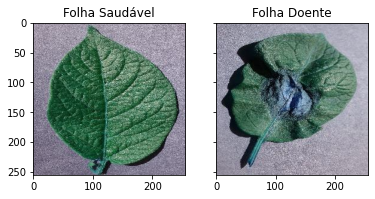

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(np.squeeze(img_saudavel[0]),cmap = plt.cm.gray)
ax1.set_title("Folha Saudável")
ax2.imshow(np.squeeze(img_doente[0]),cmap = plt.cm.gray)
ax2.set_title("Folha Doente")

In [ ]:
print(img_saudavel.shape)
print(img_doente.shape)

(152, 256, 256, 3)
(2000, 256, 256, 3)


#### Pré-processamento

In [ ]:
# Data augmentation nas imagens de folhas saudáveis
def augmentation(imagens):
  aug = tf.image.flip_left_right(imagens)
  img_aug = [*imagens,*aug]
  aug = tf.image.random_brightness(imagens,max_delta = 0.35)
  img_aug = [*img_aug,*aug]
  aug = tf.image.random_contrast(imagens, 0.3, 2.5)
  img_aug = [*img_aug,*aug]
  return(np.array(img_aug))

tf.Tensor([608 256 256   3], shape=(4,), dtype=int32)


Text(0.5, 1.0, 'Contraste Aleatório')

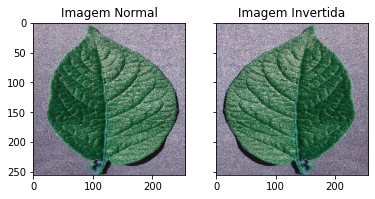

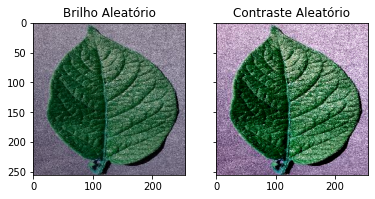

In [ ]:
img_saudavel_aug = augmentation(img_saudavel)
print(tf.shape(img_saudavel_aug))

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.imshow(np.squeeze(img_saudavel_aug[0]),cmap = plt.cm.gray)
ax1.set_title("Imagem Normal")
ax2.imshow(np.squeeze(img_saudavel_aug[152]),cmap = plt.cm.gray)
ax2.set_title("Imagem Invertida")

f2, (ax3, ax4) = plt.subplots(1, 2, sharey=True)
ax3.imshow(np.squeeze(img_saudavel_aug[304]),cmap = plt.cm.gray)
ax3.set_title("Brilho Aleatório")
ax4.imshow(np.squeeze(img_saudavel_aug[456]),cmap = plt.cm.gray)
ax4.set_title("Contraste Aleatório")

In [ ]:
from sklearn.model_selection import train_test_split

img_saudavel_aug = augmentation(img_saudavel_aug)
#img_saudavel_aug = augmentation(img_saudavel_aug)

img_doente_aug = augmentation(img_doente)
#img_doente_aug = augmentation(img_doente_aug)

x = np.array([*img_saudavel_aug,*img_doente_aug])
y = np.array([*np.zeros(len(img_saudavel_aug)),*np.ones(len(img_doente_aug))])     # 0 = saudável, 1 = doente

#x = np.array([*img_saudavel,*img_doente])
#y = np.array([*np.zeros(len(img_saudavel)),*np.ones(len(img_doente))])

xtrain, xtest, ytrain, ytest = train_test_split(x,y,test_size=0.2)
xtrain, xval, ytrain, yval = train_test_split(xtrain,ytrain,test_size=0.2)

xtrain.shape, xtest.shape, xval.shape

((6676, 256, 256, 3), (2087, 256, 256, 3), (1669, 256, 256, 3))

In [ ]:
img_saudavel_aug.shape, img_doente_aug.shape

((2432, 256, 256, 3), (8000, 256, 256, 3))

In [ ]:
# Normalização
#datagen = ImageDataGenerator(rescale=1./255,
                            #rotation_range=40,
                            #width_shift_range=0.2,
                            #height_shift_range=0.2,
                            #shear_range=0.2,
                            #zoom_range=0.2,
                            #horizontal_flip=True)

# prepare an iterators to scale images
#train_iterator = datagen.flow(xtrain, ytrain, batch_size=64, shuffle=True)
#test_iterator = datagen.flow(xtest, ytest, batch_size=64, shuffle=True)
#val_iterator = datagen.flow(xval, yval, batch_size=64, shuffle=True)
#print('Batches train=%d, test=%d, val=%d' % (len(train_iterator), len(test_iterator), len(val_iterator)))

# confirm the scaling works
#batchX, batchy = train_iterator.next()
#print('Batch shape=%s, min=%.3f, max=%.3f' % (batchX.shape, batchX.min(), batchX.max()))

### Modelo

In [ ]:
# Criando o modelo
model = Sequential()

model.add(Rescaling(scale=1./255, input_shape=(256,256,3)))   # Normalização

model.add(Conv2D(32, (3,3), activation='relu', kernel_regularizer='l2'))  # Convolução
model.add(MaxPooling2D(pool_size = (2,2))) # Pooling
#model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Conv2D(32, (3,3), activation='relu',kernel_regularizer='l2'))  # Convolução
model.add(MaxPooling2D(pool_size = (2,2))) # Pooling
#model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Conv2D(32, (3,3), activation='relu',kernel_regularizer='l2'))  # Convolução
model.add(MaxPooling2D(pool_size = (2,2))) # Pooling
#model.add(Dropout(0.3))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(16, activation='relu',kernel_regularizer='l2'))
model.add(Dropout(0.5))
#model.add(Dense(16, activation='relu',kernel_regularizer='l2'))
#model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 127, 127, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0

In [ ]:
# Compilando o modelo
opt = Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.01, amsgrad=False)
model.compile(optimizer=opt, 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

In [ ]:
# Treinando o modelo
batch = 64
epocas = 20
history = model.fit(xtrain, ytrain, 
                    validation_data = (xtest,ytest), 
                    batch_size = batch, 
                    epochs = epocas
                    )

Epoch 1/20


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


105/105 [==============================] - 14s 112ms/step - loss: 1.1691 - accuracy: 0.9280 - val_loss: 1.9909 - val_accuracy: 0.7758
Epoch 2/20
105/105 [==============================] - 11s 102ms/step - loss: 1.0297 - accuracy: 0.9778 - val_loss: 2.4483 - val_accuracy: 0.7758
Epoch 3/20
105/105 [==============================] - 11s 103ms/step - loss: 0.9984 - accuracy: 0.9810 - val_loss: 1.9699 - val_accuracy: 0.7916
Epoch 4/20
105/105 [==============================] - 11s 108ms/step - loss: 0.9741 - accuracy: 0.9847 - val_loss: 1.5075 - val_accuracy: 0.8467
Epoch 5/20
105/105 [==============================] - 11s 102ms/step - loss: 0.9542 - accuracy: 0.9862 - val_loss: 1.0431 - val_accuracy: 0.9391
Epoch 6/20
105/105 [==============================] - 11s 102ms/step - loss: 0.9349 - accuracy: 0.9876 - val_loss: 0.9519 - val_accuracy: 0.9775
Epoch 7/20
105/105 [==============================] - 11s 102ms/step - loss: 0.9239 - accuracy: 0.9906 - val_loss: 0.9069 - val_accuracy: 0.9

In [ ]:
model.save('gdrive/My Drive/Dataset/Batata/Resultados')

INFO:tensorflow:Assets written to: gdrive/My Drive/Dataset/Batata/Resultados/assets


In [ ]:
import pickle
with open('gdrive/My Drive/Dataset/Batata/Resultados_Resnet/trainHistoryDict', 'wb') as file_pi:
  pickle.dump(history.history, file_pi)

#### Avaliando o modelo

In [ ]:
model = keras.models.load_model('gdrive/My Drive/Dataset/Batata/Resultados')
history = pickle.load(open('gdrive/My Drive/Dataset/Batata/Resultados_Resnet/trainHistoryDict', "rb"))

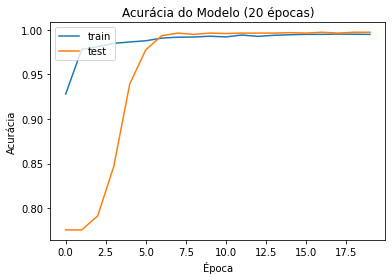

In [ ]:
# Acurácia
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(f'Acurácia do Modelo ({epocas} épocas)')
plt.ylabel('Acurácia')
plt.xlabel('Época')
plt.legend(['train', 'test'], loc='upper left')

plt.savefig("acuracia.png", dpi = 300)
!cp acuracia.png "gdrive/My Drive/Dataset/Batata/Resultados"

plt.show()

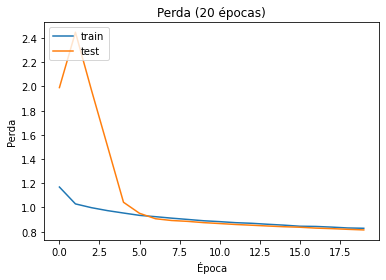

In [ ]:
# Perda
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(f'Perda ({epocas} épocas)')
plt.ylabel('Perda')
plt.xlabel('Época')
plt.legend(['train', 'test'], loc='upper left')

plt.savefig("perda.png", dpi = 300)
!cp perda.png "gdrive/My Drive/Dataset/Batata/Resultados"

plt.show()

In [ ]:
ypred = model.predict(xtest)

In [ ]:
# Matriz de Confusão
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

array = confusion_matrix(ytest,np.round(ypred))

print(array)
print('\nAcurácia:',accuracy_score(ytest, np.round(ypred)))

[[ 466    2]
 [   4 1615]]

Acurácia: 0.9971250598945856


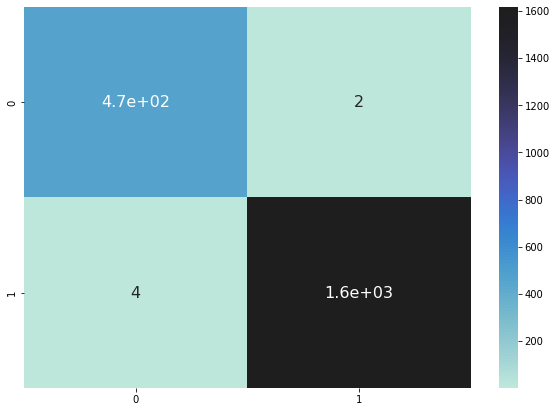

In [ ]:
import pandas as pd
import seaborn as sn
from matplotlib.pyplot import figure

df_cm = pd.DataFrame(array, index = [i for i in "01"], columns = [i for i in "01"])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, center = np.amax(array))

plt.savefig("conf_mlp.png", dpi = 300, transparent = True)
!cp conf_mlp.png "gdrive/My Drive/Dataset/Batata/Resultados/"

plt.show()

#### Fazendo previsões

In [ ]:
# Dataset de validação
ypred = model.predict(xval)
array = confusion_matrix(yval, np.round(ypred))

print(array)
print('\nAcurácia:',accuracy_score(yval, np.round(ypred)))

[[ 369    4]
 [   3 1293]]

Acurácia: 0.9958058717795086


In [ ]:
# Testando com imagens individuais (folhas saudáveis)
def ler_imagem(file_list):
  img = cv2.imread(file_list)
  img = img.reshape(1,256,256,3)
  #img = np.array(tf.image.rgb_to_grayscale(img))
  return(img)

file_list = 'gdrive/My Drive/Dataset/Batata/folha_saudavel_1.png'
batata_1 = ler_imagem(file_list)

file_list = 'gdrive/My Drive/Dataset/Batata/folha_saudavel_2.png'
batata_2 = ler_imagem(file_list)

file_list = 'gdrive/My Drive/Dataset/Batata/folha_saudavel_3.png'
batata_3 = ler_imagem(file_list)

file_list = 'gdrive/My Drive/Dataset/Batata/folha_saudavel_4.jpg'
batata_4 = ler_imagem(file_list)



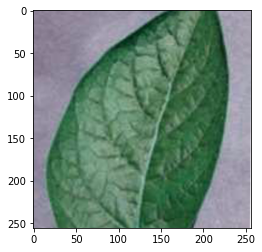

In [ ]:
plt.imshow(np.squeeze(batata_1), cmap = plt.cm.gray)

In [ ]:
print(model.predict(batata_1))
print(model.predict(batata_2))
print(model.predict(batata_3))
print(model.predict(batata_4))

[[0.21031034]]
[[0.02603454]]
[[0.62523204]]
[[0.0010216]]


In [ ]:
# Testando com novas imagens

val_saudavel = [] 
val_doente = []

file_list = glob.glob(r'gdrive/My Drive/Dataset/Batata_val/Healthy/*.*')
val_saudavel = ler(file_list, val_saudavel)

file_list = glob.glob(r'gdrive/My Drive/Dataset/Batata_val/Late_Blight/*.*')
val_doente = ler(file_list, val_doente)

x_novo = np.array([*val_saudavel,*val_doente])
ypred = model.predict(x_novo)

ytest_val = np.array([*np.zeros(len(val_saudavel)),*np.ones(len(val_doente))])   

array = confusion_matrix(ytest_val, np.round(ypred))

print(array)
print('\nAcurácia:',accuracy_score(ytest_val, np.round(ypred)))

[[ 17  85]
 [  1 140]]

Acurácia: 0.6460905349794238
